# Udacity Machine Learning Nanodegree Capstone Project

### UK Criminal Sentencing Regression Project

Welcome to my capstone Udacity Machine Learning Nanodegree project. In this notebook, you will find all of my workings on how to reproduce the results describe in the project report. 

Due to the size of the dataset, some instructions are required for acquiring it. Please visit the download link at: 

http://www.justice.gov.uk/downloads/publications/statistics-and-data/criminal-justice-stats/recordlevel.zip

and place the file in the same directory as this notebook. Running the first cell of this notebook will then remove all records in the data that do not relate to actual custodial sentences. 


#### Table of contents

1. Filter out non-custodial data
2. Let's do some pre-processing and create continuous variables
3. Let's explore our data!
4. Let's make some visuals for our data
5. Let's encoded some relevant variables
6. Check Correlation
7. Feature Selection
8. Split the data
9. Defining a Performance Metric
10. Benchmark Model
11. Parameter Optimisation
12. Let's Train Our Model!
13. Evaluating the Model
14. Let's make some predictions about some cases here and evaluate whether or not the are reasonable

#### 1. Filter out non-custodial data and print some info

In [1]:
import numpy as np
import pandas as pd

## filter warnings after seeing them once
import warnings
warnings.filterwarnings(action ='once')

%matplotlib inline

## read data to data frame
data = pd.read_csv('recordlevel.csv', index_col=False)
# index column is still present. I've tried debugging, currently unsure how to fix

## filter out any sentence with the outcome of 'fine'
data = data[data.Sentence_Outcome != 'Fine']

## filter out sentences with unknown durations
data = data[data.amount.notnull()]

## save data to csv
data.to_csv('custodial_sentences.csv')

## print number of remaining records
print("Number of records after removing irrelevant data: {}").format(data.shape[0])

Number of records after removing irrelevant data: 97814


#### 2. Let's do some pre-processing and create continuous variables

First, here's what the data looks like to begin with

In [2]:
data.head()

,AGE,court,Offence_type,Sentence_Outcome,amount,force,sex,Ethnicity,offence_to_completion
3,18-24,Croydon,Burglary,Immediate custody,up to and including 3 months,Metropolitan Police,Male,White,Not Available
17,25-34,Highbury Corner,Burglary,Immediate custody,Over 3 months and up to and including 6 months,Metropolitan Police,Male,White,less than 6 months
32,25-34,Bexley,Shoplifting,Immediate custody,up to and including 3 months,Metropolitan Police,Female,White,less than 6 months
39,25-34,Camberwell Green/Tower Bridge,Driving Offences,Immediate custody,up to and including 3 months,Metropolitan Police,Male,Black,Not Available
48,25-34,Croydon,Shoplifting,Immediate custody,up to and including 3 months,Metropolitan Police,Female,White,less than 6 months


Now let's import some dictionaries attained from other data sources and create some continuous variables from our categories. The reasons for this are outlined in the report

In [3]:
import json

## import dictionary of sentences lengths to continuous variables

continuous_sentencing_variables_dictionary = {}

with open("sentence_amount.txt") as file:
    for line in file:
        key, value = line.strip().split(':')
        continuous_sentencing_variables_dictionary[key] = int(value)
        
## print dictionary    
print(json.dumps(continuous_sentencing_variables_dictionary, indent=2))

{
  "4 Years": 48, 
  "Over 4 years and up to and including 5 years": 48, 
  "Over 5 years and up to and including 10 years": 60, 
  "Over 18 months and up to and including 3 years": 18, 
  "Over 3 years and less than 4 years": 36, 
  "up to and including 3 months": 2, 
  "Over 3 months and up to and including 6 months": 3, 
  "Over 6 months to less than 12": 6, 
  "Over 10 years and less than life": 120, 
  "12 months": 12, 
  "Life or Indeterminate Sentence": 180, 
  "Over 12 months and up to and including 18 months": 12
}


In [4]:
## replace the sentencing bands with integers representing the minimal sentence in months

data = data.replace({"amount":continuous_sentencing_variables_dictionary})

In [5]:
import json

## import dictionary of crime severity to continuous variables

continuous_offence_variables_dictionary = {}

with open("offence_severity.txt") as file:
    for line in file:
        key, value = line.strip().split(':')
        continuous_offence_variables_dictionary[key] = int(value)
        
## print dictionary    
print(json.dumps(continuous_offence_variables_dictionary, indent=2))

{
  "Murder": 2350, 
  "Robbery": 746, 
  "Shoplifting": 13, 
  "Supply of drugs": 497, 
  "Other Crime": 524, 
  "Other Drugs": 11, 
  "Driving Offences": 546, 
  "Violent Crime": 365, 
  "Possession of drugs": 6, 
  "Other Theft": 33, 
  "Production/importation of drugs": 496, 
  "Vehicle Crime": 36, 
  "Burglary": 703, 
  "Criminal Damage and Arson": 8, 
  "Public Disorder and Possession of weapons": 37
}


In [6]:
## replace the offences with integers representing the approximate weighted crime severity 

data = data.replace({"Offence_type":continuous_offence_variables_dictionary})

In [7]:
import json

## import dictionary of age groups to continuous variables

continuous_age_groups_variables_dictionary = {}

with open("age_groups.txt") as file:
    for line in file:
        key, value = line.strip().split(':')
        continuous_age_groups_variables_dictionary[key] = int(value)
        
## print dictionary    
print(json.dumps(continuous_age_groups_variables_dictionary, indent=2))

{
  "35+": 50, 
  "18-24": 21, 
  "25-34": 29
}


In [8]:
## replace the offences with integers representing the average age of each age band topping out at 65

data = data.replace({"AGE":continuous_age_groups_variables_dictionary})

In [9]:
import json

## import dictionary of offence to completion to continuous variables

continuous_offence_to_completion_variables_dictionary = {}

with open("offence_to_completion.txt") as file:
    for line in file:
        key, value = line.strip().split(':')
        continuous_offence_to_completion_variables_dictionary[key] = int(value)
        
## print dictionary    
print(json.dumps(continuous_offence_to_completion_variables_dictionary, indent=2))

{
  "1 to 2 years": 12, 
  "6 months to 1 year": 6, 
  "Not Available": 12, 
  "less than 6 months": 3, 
  "greater than 2 years": 24
}


In [10]:
## replace the offence to completion with integers representing the offence to completion in months

data = data.replace({"offence_to_completion":continuous_offence_to_completion_variables_dictionary})

In [11]:
## output the data as a csv for sanity checks

data.to_csv('custodial_sentences_with_continuous_variable.csv')

#### 3. Let's explore our data!

Now that we have only data relevant for our purposes remaining and converted some variables into continous variables, let's explore it.

In [12]:
## we could just use describe for this but I prefer it to 
## be more explicit, plus there is only one continuous variable

# sentences is our prediction target
sentences = data['amount']

minimum_sentence = np.min(sentences)

maximum_sentence = np.max(sentences)

mean_sentence = np.mean(sentences)

median_sentence = np.median(sentences)

std_sentence = np.std(sentences)

print "Sentencing data at a glance"
print "There are {} records".format(data.shape[0])
print "Minimum sentence: {} months".format(minimum_sentence)
print "Maximum sentence: {} months".format(maximum_sentence)
print "Mean sentence: {} months".format(mean_sentence)
print "Median sentence {} months".format(median_sentence)
print "Standard deviation: {}".format(std_sentence)


Sentencing data at a glance
There are 97814 records
Minimum sentence: 2 months
Maximum sentence: 180 months
Mean sentence: 12.9878340524 months
Median sentence 3.0 months
Standard deviation: 24.8257878998


##### Here's a look at whar the data looks like

In [13]:
display(data.head())

,AGE,court,Offence_type,Sentence_Outcome,amount,force,sex,Ethnicity,offence_to_completion
3,21,Croydon,703,Immediate custody,2,Metropolitan Police,Male,White,12
17,29,Highbury Corner,703,Immediate custody,3,Metropolitan Police,Male,White,3
32,29,Bexley,13,Immediate custody,2,Metropolitan Police,Female,White,3
39,29,Camberwell Green/Tower Bridge,546,Immediate custody,2,Metropolitan Police,Male,Black,12
48,29,Croydon,13,Immediate custody,2,Metropolitan Police,Female,White,3


In [14]:
print "The full dataset is", data.shape[0],"rows x", data.shape[1], "columns"

The full dataset is 97814 rows x 9 columns


##### 4.  Let's make some visuals for our data

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

visual = plt.figure(figsize=(8, 8))
visual.suptitle('Visualization of Exploring the Data', fontsize=12, y=1.03)

figure_1 = visual.add_subplot(321)
sns.distplot(data['amount'], hist_kws={'color': 'pink', 'alpha': 1}, kde=False, ax=figure_1)
figure_1 .set_xlabel('Duration of Sentence')
figure_1 .set_ylabel('Defendants')

figure_2 = visual.add_subplot(322)
sns.distplot(data['offence_to_completion'], hist_kws={'color': 'pink', 'alpha': 1}, kde=False, ax=figure_2)
figure_2 .set_xlabel('Time from offence to sentencing')
figure_2 .set_ylabel('Defendants')

figure_3 = visual.add_subplot(323)
sns.distplot(data['Offence_type'], hist_kws={'color': 'pink', 'alpha': 1}, kde=False, ax=figure_3)
figure_3 .set_xlabel('Weighted Offence Category')
figure_3 .set_ylabel('Defendants')

figure_4 = visual.add_subplot(324)
sns.distplot(data['AGE'], hist_kws={'color': 'pink', 'alpha': 1}, kde=False, ax=figure_4)
figure_4 .set_xlabel('Age')
figure_4 .set_ylabel('Defendants')

plt.tight_layout()

##### Observations

- The age categories in which people were convicted of offences were quite evenly spread amoung the three categories but was slightly higher in the 25-34 category. It seems that convictions drop off significantly after the age of 35 as there are fewer people in the entire bracket of 35+ than there are in 25-34 and about the same as is in 18-24.

- There were far more people being convicted of lower level offences and the more serious the offence, the fewer convictions there were. This may mean that there were fewer of these types of offences or that they are harder to prove beyond reasonable doubt and defendants are less likely to plead guilty to them. 

- Most defendants were processed by the criminal justice system relatively quickly. Most cases moved from offence to completion in less than 6 months. 

- A large amount more defendants were sent to prison for very short sentences of "up to and including 3 months." This type of sentence can be very disruptive to a persons life. This will be discussed further in the report. 




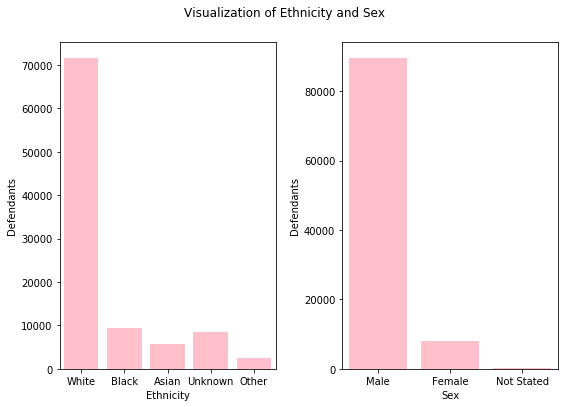

In [16]:
visual = plt.figure(figsize=(8, 10))
visual.suptitle('Visualization of Ethnicity and Sex', fontsize=12, x=0.5, y=1.03)


figure_1 = plt.subplot2grid((2, 2), (0, 0), colspan=1)
figure_1 = sns.countplot(x='Ethnicity', data=data, ax=figure_1, saturation=1, facecolor='pink')
figure_1.set_xlabel('Ethnicity')
figure_1.set_ylabel('Defendants')

figure_2 = plt.subplot2grid((2, 2), (0, 1), colspan=1)
figure_2 = sns.countplot(x='sex', data=data, ax=figure_2, saturation=1, facecolor='pink')
figure_2.set_xlabel('Sex')
figure_2.set_ylabel('Defendants')

plt.tight_layout()

##### Observations

- A much higher proportion of ethnically white people were convicted of crimes and sentenced to custodial sentences than any other ethnicity. 

- A much higher proportion of men received custodial sentences than women. 

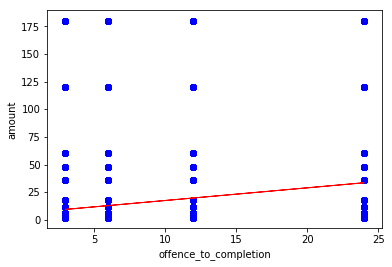

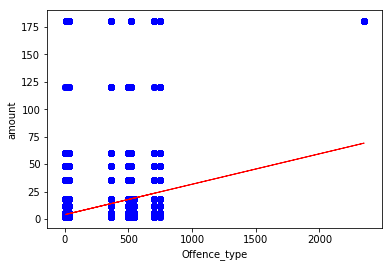

In [26]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression


def test_theory(input, feature):
    reg = LinearRegression()
    features = input[feature].values.reshape(-1, 1)
    reg.fit(features, sentences)
    plt.plot(features, reg.predict(features), color='red', linewidth=1)
    plt.scatter(features, sentences, alpha=0.5, color='blue')
    plt.xlabel(feature)
    plt.ylabel('amount')
    plt.show()
    
test_theory(data, 'offence_to_completion')
test_theory(data, 'Offence_type') 

##### Observations

- It's very difficult to tell correlation on the graph due to the nature of the values being more like categories than actual continuous variables but with the linear regression line, we can see a clear correlation with offence to completion and offence category. 


#### 5. Let's encoded some relevant variables

I think categories like gender and ethnicity may be very useful and I don't want to lose this dimensionality because they are categorical variables so here I will encode them to binary variables.

In [18]:
ethnicity_encoded = pd.get_dummies(data['Ethnicity'])
data = data.join(ethnicity_encoded)

sex_encoded = pd.get_dummies(data['sex'])
data = data.join(sex_encoded)

data.tail()

,AGE,court,Offence_type,Sentence_Outcome,amount,force,sex,Ethnicity,offence_to_completion,Asian,Black,Other,Unknown,White,Female,Male,Not Stated
1266714,29,Newport (I.O.W) CC,746,Immediate custody,36,Hampshire,Male,White,6,0,0,0,0,1,0,1,0
1266715,29,Newport (I.O.W) CC,37,Immediate custody,60,Hampshire,Male,White,12,0,0,0,0,1,0,1,0
1266716,29,Newport (I.O.W) CC,497,Immediate custody,48,Hampshire,Male,White,12,0,0,0,0,1,0,1,0
1266719,50,Salisbury CC,524,Immediate custody,3,Wiltshire,Male,White,12,0,0,0,0,1,0,1,0
1266720,50,Salisbury CC,36,Immediate custody,2,Wiltshire,Male,White,12,0,0,0,0,1,0,1,0


###### 6. Check Correlation

The above scatter plots don't provide much insight in terms of the strength of correlation right now so a correlation matrix or correlation heatmap might justify our theory more strongly that offence to completion and offence category are strong indicators of the length of sentence. 

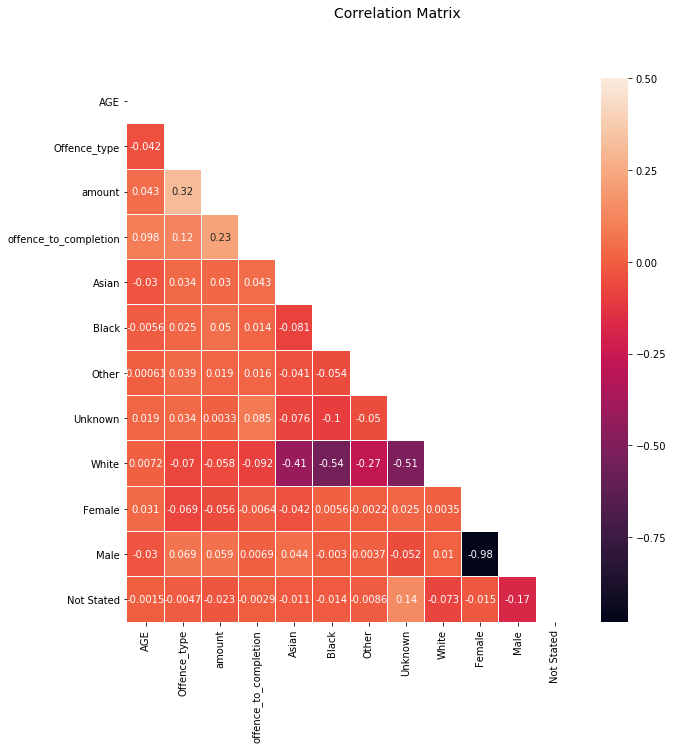

In [19]:
correlation = data.corr()

figure_1 = plt.figure(figsize=(10, 10))
figure_1.suptitle('Correlation Matrix', fontsize=14)
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(correlation, annot=True, mask=mask, vmax=0.5,linewidths=0.1)

##### Observations

- As a sanity check, I am pleased that being male correlates so strongly with not being female and being white correlates strongly with not being black. 

- As expected the duration of the sentence appears to correlate strongly with the weighted severity of the offence

- Surprisingly, but understandably, the duration of the sentence appears to correlate most strongly with the length of time between the offence and sentencing. Reasons for this are discussed in the report

#### 7. Feature Selection

Now we can drop the data that we won't use and the categories that have now been encoded.

In [20]:
features = data.drop(["amount","court", "Sentence_Outcome","force","sex","Ethnicity"], axis=1)

print "The features remaining are {}".format(features.columns.values)

The features remaining are ['AGE' 'Offence_type' 'offence_to_completion' 'Asian' 'Black' 'Other'
 'Unknown' 'White' 'Female' 'Male' 'Not Stated']


Here's what our features looks like now

In [21]:
features.describe()

,AGE,Offence_type,offence_to_completion,Asian,Black,Other,Unknown,White,Female,Male,Not Stated
count,97814.000000,97814.000000,97814.000000,97814.000000,97814.000000,97814.000000,97814.000000,97814.000000,97814.000000,97814.000000,97814.000000
mean,33.190372,322.352291,6.107347,0.057691,0.097236,0.026213,0.086010,0.732850,0.081215,0.916075,0.002709
std,11.951202,284.706930,4.924289,0.233160,0.296280,0.159769,0.280381,0.442474,0.273167,0.277276,0.051980
min,21.000000,6.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,33.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,29.000000,365.000000,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,50.000000,524.000000,6.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,50.000000,2350.000000,24.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### 8. Split the data

In [27]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, sentences, random_state=7, test_size=0.20)

print "Training and testing split completed."

Training and testing split completed.


#### 9. Defining a Performance Metric

The performance metric used is the r2 score and the mean squared error

In [23]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    score = r2_score(y_true, y_predict)
    return score

#### 10. Benchmark Model

I have used two bench mark models. I initially tried a linear regression model but it felt so basic and performed so poorly that I tried a single feature decision tree regressor with three different max depths and they did not perform significantly better. 


Variance score: 0.10


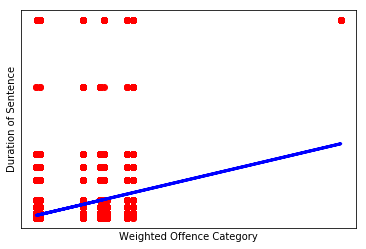

In [59]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import r2_score

regr = linear_model.LinearRegression()

regr.fit(X_train["Offence_type"].values.reshape(-1, 1), y_train.values.reshape(-1, 1))

y_pred = regr.predict(X_test["Offence_type"].values.reshape(-1, 1))

print('Variance score: %.2f' % r2_score(y_test, y_pred))

plt.scatter(X_test["Offence_type"], y_test,  color='red')
plt.plot(X_test["Offence_type"], y_pred, color='blue', linewidth=3)

plt.xlabel("Weighted Offence Category")
plt.ylabel('Duration of Sentence')

plt.xticks(())
plt.yticks(())

plt.show()

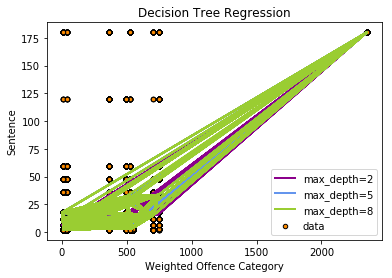

R^2 score for decision tree regressor with a max depth of 2 = -3.46
R^2 score for decision tree regressor with a max depth of 5 = -1.93
R^2 score for decision tree regressor with a max depth of 8 = -1.90


In [52]:
from sklearn.tree import DecisionTreeRegressor

regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_3 = DecisionTreeRegressor(max_depth=8)

regr_1.fit(X_train["Offence_type"].values.reshape(-1, 1), y_train)
regr_2.fit(X_train["Offence_type"].values.reshape(-1, 1), y_train)
regr_3.fit(X_train["Offence_type"].values.reshape(-1, 1), y_train)

pred_y_1 = regr_1.predict(X_test["Offence_type"].values.reshape(-1, 1))
pred_y_2 = regr_2.predict(X_test["Offence_type"].values.reshape(-1, 1))
pred_y_3 = regr_3.predict(X_test["Offence_type"].values.reshape(-1, 1))

plt.figure()
plt.scatter(X_train["Offence_type"], y_train, s=20, edgecolor="black",
            c="darkorange", label="data")

plt.plot(X_test["Offence_type"], pred_y_1, color="darkmagenta",
         label="max_depth=2", linewidth=2)
r2_score_1 = performance_metric(pred_y_1, y_test)

plt.plot(X_test["Offence_type"], pred_y_2, color="cornflowerblue", label="max_depth=5", linewidth=2)
r2_score_2 = performance_metric(pred_y_2, y_test)

plt.plot(X_test["Offence_type"], pred_y_3, color="yellowgreen",
         label="max_depth=8", linewidth=2)
r2_score_3 = performance_metric(pred_y_3, y_test)

plt.xlabel("Weighted Offence Category")
plt.ylabel("Sentence")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

print "R^2 score for decision tree regressor with a max depth of 2 = %.2f" % r2_score_1
print "R^2 score for decision tree regressor with a max depth of 5 = %.2f" % r2_score_2
print "R^2 score for decision tree regressor with a max depth of 8 = %.2f" % r2_score_3

#### 11. Parameter Optimisation

o
o
o
o
o
oLet's have some learning curves and model complexity graphs here
o
o
o
o


Here I use the grid search method to optimise the Decision Tree Regressor and obtain the optimal parameters for training the model.

In [33]:
from sklearn.metrics import make_scorer
from sklearn.cross_validation import ShuffleSplit
from sklearn.grid_search import GridSearchCV

def fit_model(X, y):
    cv_sets = ShuffleSplit(X.shape[0], n_iter=10, test_size=0.1, train_size=None, random_state=None)

    regressor = DecisionTreeRegressor()
    scoring_fnc = make_scorer(performance_metric)
    grid = GridSearchCV(regressor, params, scoring_fnc, cv=cv_sets)
    grid = grid.fit(X, y)

    return grid.best_estimator_


In [32]:
params = {'max_depth': list(range(1,11))}

reg = fit_model(X_train["Offence_type"].values.reshape(-1, 1), y_train.values.reshape(-1, 1))

In [34]:
print "Parameter 'max_depth' is {} for the optimal model.".format(reg.get_params()['max_depth'])

Parameter 'max_depth' is 10 for the optimal model.


Learning Curves

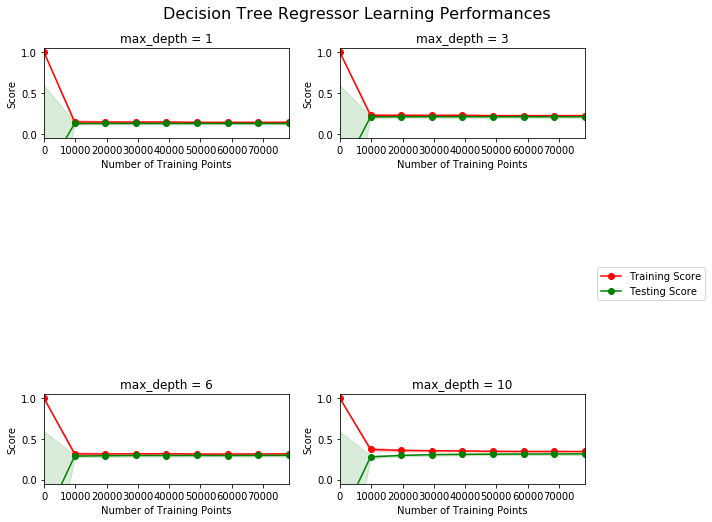

In [39]:
import visuals as vs

vs.ModelLearning(features, sentences)


Model Complexity

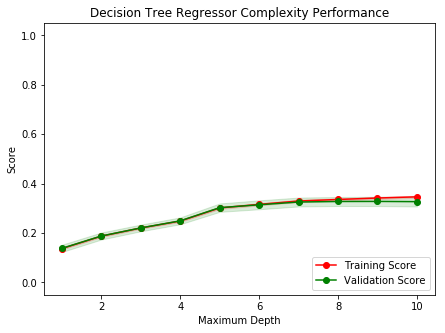

In [38]:
vs.ModelComplexity(X_train, y_train)

#### 12. Let's Train Our Model! 

In [40]:
regressor = DecisionTreeRegressor(max_depth=7)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=7, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

#### 13. Evaluating the Model

Visualisations?

In [58]:
R_2 = performance_metric(y_test, regressor.predict(X_test))

print("R2 Score: {}".format(R_2))

R2 Score: 0.325214733155


#### 14. Let's make some predictions about some cases here and evaluate whether or not the are reasonable

In [42]:
defendent_features = [[29,746,6,0,0,0,0,1,0,1,0],[29,13,3,0,0,0,0,1,1,0,0],
                      [50,36,12,0,0,0,0,1,0,1,0]]

for i, sentence in enumerate(regressor.predict(defendent_features)):
    print "Predicted custodial sentences for Defendant {} is: {:,.2f} months".format(i+1, sentence)

Predicted custodial sentences for Defendant 1 is: 51.22 months
Predicted custodial sentences for Defendant 2 is: 2.17 months
Predicted custodial sentences for Defendant 3 is: 8.31 months
